<a href="https://colab.research.google.com/github/deybvagm/natural-language-processing/blob/master/imdb_subword_token_comparison_nn_lstm_gru_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comparison of different neural-network-based models applied to the subword8k IMDB dataset

The aim of this notebook is to compare different models to solve a binary classification problem. The dataset used is the IMDB movie review dataset in which a bunch of reviews are given and the classification task is to determine whether a review is positive or not. A rreview is considered positive if the rating is between 7-10 stars and is negative if the rating is between 0-4 stars

The models used are:

- Standard neural network
- Single Layer LSTM (Bidirectional)
- 2 Layer LSTM (Bidirectional)
- Bidirectional GRU
- CNN


No regularization techniques are used for the models

## Importing libraries and downloading the dataset

In [0]:
import tensorflow as tf
print(tf.__version__)

1.14.0


In [0]:
! pip install tensorflow-gpu==2.0.0-rc0

     |████████████████████████████████| 380.5MB 61kB/s 
     |████████████████████████████████| 501kB 25.6MB/s 
     |████████████████████████████████| 4.3MB 33.7MB/s 
     |████████████████████████████████| 71kB 25.6MB/s 
  Created wheel for opt-einsum: filename=opt_einsum-3.0.1-cp36-none-any.whl size=58500 sha256=387bf086a4627c3ad86d438cc260d4aeca2e789420e03ebea231894ec85e93d3
  Stored in directory: /root/.cache/pip/wheels/91/98/8d/10e3d4e04c959597a411b91acd3695e9e2d210e68ce3427aad
Successfully built opt-einsum


In [0]:
import tensorflow as tf
print(tf.__version__)

2.0.0-rc0


In [0]:
! pip install -q tensorflow-datasets

     |████████████████████████████████| 2.3MB 5.1MB/s 


In [0]:
import tensorflow_datasets as tfds

In [0]:
imdb, info = tfds.load('imdb_reviews/subwords8k', with_info=True, as_supervised=True)

W0828 22:11:42.073417 140364887746432 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_datasets/core/file_format_adapter.py:209: tf_record_iterator (from tensorflow.python.lib.io.tf_record) is deprecated and will be removed in a future version.
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/0.1.0. Subsequent calls will reuse this data.


W0828 22:13:29.833303 140364887746432 dataset_builder.py:439] Warning: Setting shuffle_files=True because split=TRAIN and shuffle_files=None. This behavior will be deprecated on 2019-08-06, at which point shuffle_files=False will be the default for all splits.


## Preprocessing the dataset

In this dataset the tokenizer is available for us, and all we need to do is to pad the data and train in minibatches

In [0]:
train_data, test_data = imdb['train'], imdb['test']

In [0]:
tokenizer = info.features['text'].encoder

In [0]:
print(tokenizer.subwords)

['the_', ', ', '. ', 'a_', 'and_', 'of_', 'to_', 's_', 'is_', 'br', 'in_', 'I_', 'that_', 'this_', 'it_', ' /><', ' />', 'was_', 'The_', 'as_', 't_', 'with_', 'for_', '.<', 'on_', 'but_', 'movie_', ' (', 'are_', 'his_', 'have_', 'film_', 'not_', 'ing_', 'be_', 'ed_', 'you_', ' "', 'it', 'd_', 'an_', 'he_', 'by_', 'at_', 'one_', 'who_', 'y_', 'from_', 'e_', 'or_', 'all_', 'like_', 'they_', '" ', 'so_', 'just_', 'has_', ') ', 'her_', 'about_', 'out_', 'This_', 'some_', 'ly_', 'movie', 'film', 'very_', 'more_', 'It_', 'would_', 'what_', 'when_', 'which_', 'good_', 'if_', 'up_', 'only_', 'even_', 'their_', 'had_', 'really_', 'my_', 'can_', 'no_', 'were_', 'see_', 'she_', '? ', 'than_', '! ', 'there_', 'get_', 'been_', 'into_', ' - ', 'will_', 'much_', 'story_', 'because_', 'ing', 'time_', 'n_', 'we_', 'ed', 'me_', ': ', 'most_', 'other_', 'don', 'do_', 'm_', 'es_', 'how_', 'also_', 'make_', 'its_', 'could_', 'first_', 'any_', "' ", 'people_', 'great_', 've_', 'ly', 'er_', 'made_', 'r_', 'B

In [0]:
sample_string = 'Tensorflow, from basics to mastery'
tokenized_string = tokenizer.encode(sample_string)
print('Tokenized string is: {}'.format(tokenized_string))

original_string = tokenizer.decode(tokenized_string)
print('Original string is: {}'.format(original_string))

Tokenized string is: [6307, 2327, 2934, 2, 48, 4249, 4429, 7, 2652, 8050]
Original string is: Tensorflow, from basics to mastery


In [0]:
for ts in tokenized_string:
  print('{} ------> {}'.format(ts, tokenizer.decode([ts])))

6307 ------> Ten
2327 ------> sor
2934 ------> flow
2 ------> , 
48 ------> from 
4249 ------> basi
4429 ------> cs 
7 ------> to 
2652 ------> master
8050 ------> y


In [0]:
embedding_dim = 64
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [0]:
train_data = train_data.shuffle(BUFFER_SIZE)
train_data = train_data.padded_batch(BATCH_SIZE, train_data.output_shapes)
test_data = test_data.padded_batch(BATCH_SIZE, test_data.output_shapes)

In [0]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric])
  plt.xlabel('Epochs')
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show() 


## Models

Here different neural network types are used (standard, LSTM, GRU and CNN) in order to compare the performance on the dataset

### Vanilla neural network

In [0]:

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          523840    
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 390       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 524,237
Trainable params: 524,237
Non-trainable params: 0
_________________________________________________________________


### LSTM

In [0]:
# TODO LSTM
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          523840    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 598,209
Trainable params: 598,209
Non-trainable params: 0
_________________________________________________________________


### Stacked LSTM

In [0]:
# TODO Bidirectional LSTM
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 64)          523840    
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 128)         66048     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 635,329
Trainable params: 635,329
Non-trainable params: 0
_________________________________________________________________


### GRU

In [0]:
# TODO GRU
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          523840    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                18816     
_________________________________________________________________
dense (Dense)                (None, 6)                 390       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 543,053
Trainable params: 543,053
Non-trainable params: 0
_________________________________________________________________


### CNN

In [0]:
# TODO CNN
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, embedding_dim),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          523840    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 128)         41088     
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 774       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 565,709
Trainable params: 565,709
Non-trainable params: 0
_________________________________________________________________


In [0]:
num_epochs = 10

In [0]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
history = model.fit(train_data, epochs=num_epochs, validation_data=test_data)

Epoch 1/10
391/391 [==============================] - 49s 125ms/step - loss: 0.5759 - accuracy: 0.7244 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
391/391 [==============================] - 30s 76ms/step - loss: 0.3758 - accuracy: 0.9021 - val_loss: 0.3930 - val_accuracy: 0.8748
Epoch 3/10
391/391 [==============================] - 28s 73ms/step - loss: 0.2887 - accuracy: 0.9302 - val_loss: 0.3780 - val_accuracy: 0.8716
Epoch 4/10
391/391 [==============================] - 27s 69ms/step - loss: 0.2354 - accuracy: 0.9438 - val_loss: 0.3983 - val_accuracy: 0.8697
Epoch 5/10
391/391 [==============================] - 27s 69ms/step - loss: 0.1957 - accuracy: 0.9524 - val_loss: 0.4356 - val_accuracy: 0.8666
Epoch 6/10
391/391 [==============================] - 27s 69ms/step - loss: 0.1655 - accuracy: 0.9619 - val_loss: 0.4597 - val_accuracy: 0.8627
Epoch 7/10
391/391 [==============================] - 28s 72ms/step - loss: 0.1429 - accuracy: 0.9680 - val_loss: 0.5292 - val_

## Graphs by models

### Standard neural network

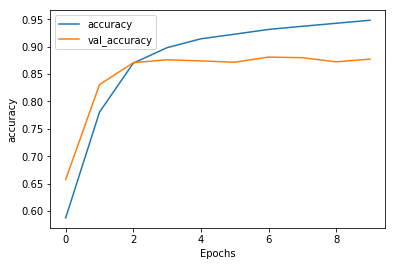

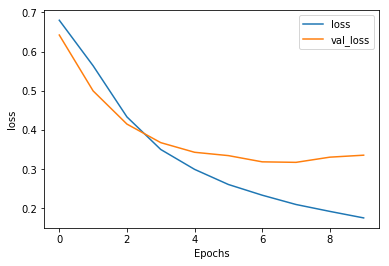

In [0]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

### Single Layer LSTM

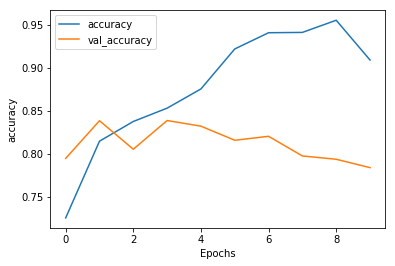

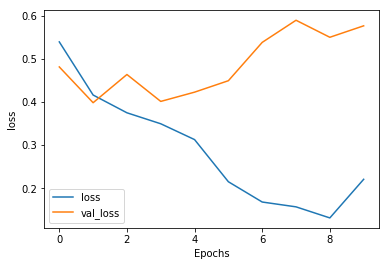

In [0]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

### Stacked LSTM

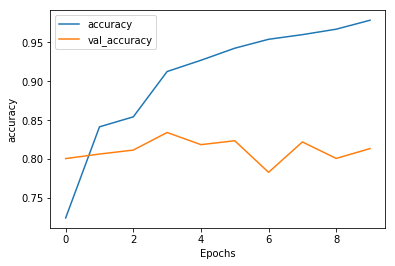

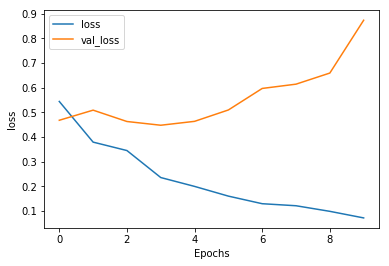

In [0]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

### GRU

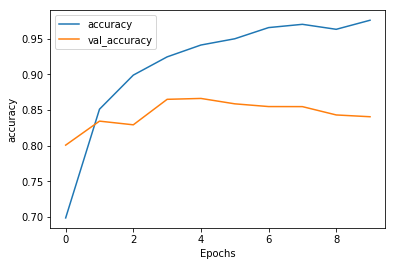

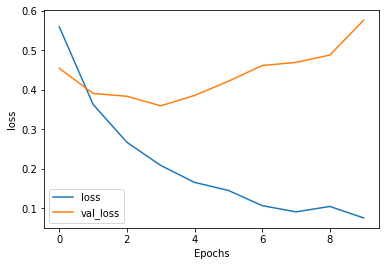

In [0]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

### CNN

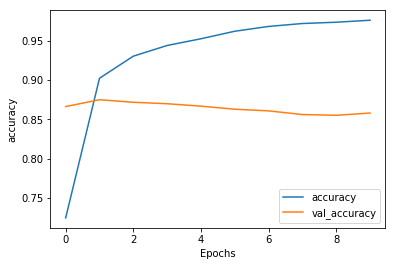

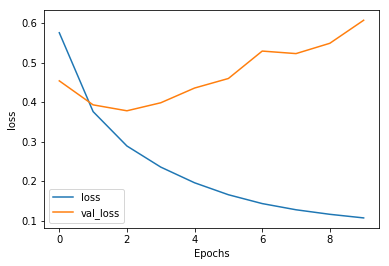

In [0]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [0]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for word_num in range(1, tokenizer.vocab_size):
  word = tokenizer.decode([word_num])
  embeddings = weights[word_num]
  out_m.write(word + '\n')
  out_v.write('\t'.join([str(x) for x in embeddings]) + '\n')
out_m.close()
out_v.close()

(8185, 64)


In [0]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

## Visualización de los embeddings

Con los archivos descargados, se puede ir al [Tensorflow Embedding Projector](https://projector.tensorflow.org) e importarlos para ver la visualización